In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from scipy.signal import savgol_filter, medfilt
from scipy.optimize import minimize

import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py'>

In [3]:
data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'
# data_dir = '/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed'

file = f'{data_dir}/sphere_data/sphere_20250103_recon_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['recon_data_all']
    hist = g['hist'][:]
    n_window = g['hist'].attrs['n_windows']
    scaling = g['hist'].attrs['scaling']

    rate_all = g['rate_hist'][:]
    rate_all_err = g['rate_hist_err'][:]
    bc = g['bc'][:]

    time_all = g.attrs['time_hours']

    fout.close()

file = f'{data_dir}/sphere_data/sphere_20250103_calibration_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['calibration_data_processed']
    eff_coefs = g['sig_efficiency_fit_params'][:]
    fout.close()

In [4]:
from scipy.special import erf, zeta

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def power_law_corrected(x, xmin, a, eff_coefs=None):
    xx = np.linspace(0, 50000, 50000)

    if eff_coefs is not None:
        eff_xx = func2(xx, *eff_coefs)
        power_law_eff = eff_xx * np.power(xx, -1 * a) / zeta(a, xmin)
        power_law_eff[xx < xmin] = 0
        power_law_corrected_norm = np.trapz(power_law_eff, xx)
    else:
        power_law_corrected_norm = 1

    x = np.asarray(x)
    if eff_coefs is not None:
        eff_x = func2(x, *eff_coefs)
        ret = eff_x * np.power(x, -1 * a) / zeta(a, xmin)
    else:
        ret = np.power(x, -1 * a) / zeta(a, xmin)
    ret[x < xmin] = 0

    if ret.size == 1:
        return ret[0] / power_law_corrected_norm
    else:
        return ret / power_law_corrected_norm

# def half_gaus_mod(x, mu, m, n):
#     xx = np.linspace(0, 50000, 50000)
#     sigma = m * xx + n
#     _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

#     sigma_x = m * x + n
#     return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod(x, mu, m, n, xmin):
    xx = np.linspace(0, 50000, 50000)

    sigma = np.empty_like(xx)
    sigma[xx < xmin] = n
    sigma[xx >= xmin] = m * (xx[xx >= xmin] - xmin) + n
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    x = np.asarray(x)
    sigma_x = np.empty_like(x)
    sigma_x[x < xmin] = n
    sigma_x[x >= xmin] = m * (x[x >= xmin] - xmin) + n
    return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod_fixed(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / _norm

from scipy.special import gamma

def half_generalized_normal(x, mu, alpha, beta):
    return 2 * (beta / (2 * alpha * gamma(1 / beta)) ) * np.exp(-1 * (np.abs(x - mu) / alpha)**beta)

def half_gaus(x, sigma):
    return 2 * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x)**2 / (2 * sigma**2))

def gaus(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

def crystal_ball_rev(x, alpha, n, mu, sigma):
    # Modified from https://arxiv.org/pdf/1603.08591
    # and https://en.wikipedia.org/wiki/Crystal_Ball_function

    x = np.asarray(x)
    ret = np.empty_like(x)

    A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
    B = n / np.abs(alpha) - np.abs(alpha)

    # Flip the direction to get the tail on the positive side
    idx_gaus = ((x - mu) / sigma) < alpha
    idx_other = ((x - mu) / sigma) > alpha

    # Flip `B - ...` to `B + ...` to reverse the power law tail 
    ret[idx_gaus] = np.exp(-1 * (x[idx_gaus] - mu)**2 / (2 * sigma**2))
    ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))

    return ret

def crystal_ball_rev_normalized(x, alpha, n, mu, sigma):
    xx = np.linspace(0, 50000, 5000)
    func_val = crystal_ball_rev(xx, alpha, n, mu, sigma)
    norm = np.trapz(func_val, xx)

    x = np.asarray(x)
    if x.size == 1:
        return crystal_ball_rev(x, alpha, n, mu, sigma)[0] / norm
    else:
        return crystal_ball_rev(x, alpha, n, mu, sigma) / norm

def expo_corrected(x, cutoff, xi):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 5000)

    expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < cutoff] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    ret = np.exp(-1 * (x) / xi) / xi
    ret[x < cutoff] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm
    
def gaus_exp(x, k, mu, sigma):
    x = np.asarray(x)
    ret = np.empty_like(x)

    idx_gaus = ((x - mu) / sigma) >= (-1 * k)
    idx_other = ((x - mu) / sigma) < (-1 * k)

    ret[idx_gaus] = np.exp(-1 * (x[idx_gaus] - mu)**2 / (2 * sigma**2))
    ret[idx_other] = np.exp(k**2 / 2 + k * ((x[idx_other] - mu)/sigma))

    return ret

def expo(x, xi):
    x = np.asarray(x)
    ret = np.exp(-1 * (x) / xi) / xi

    if ret.size == 1:
        return ret[0]
    else:
        return ret

In [5]:
def get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot):
    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = a * crystal_ball_rev_normalized(bi, alpha, n, mu, sigma) + (1 - a) * expo_corrected(bi, cutoff, xi)
    mui = ntot * joint_pdf * 50

    return mui

def nll(a, alpha, n, mu, sigma, cutoff, xi, bc, hist):
    idx = bc > 1000
    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    mui = get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot)
    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [6]:
def plot_likelihood_fit(bc, hist, res_x):
    fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])
    ana_threshold = 1000

    idx = bc > ana_threshold
    bi = bc[idx]
    ntot = np.sum(hist)

    hist_norm = n_window * scaling

    hist_fit_ml = get_mui(*res_x, bi, ntot)
    a, alpha, n, mu, sigma, cutoff, xi = res_x

    ax = axes[0]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.errorbar(bi, hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)
    ax.plot(bi, hist_fit_ml, '--', color='#DC143C', label='Reversed Crystal Ball + exponential (ML)')

    xx2 = np.linspace(1020, 10000, 500)
    crystal_ball_hist = ntot * 50 * a * crystal_ball_rev_normalized(xx2, alpha, n, mu, sigma)
    ax.fill_between(xx2, 0, crystal_ball_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(cutoff, 10000, 500)
    expo_hist = ntot * 50 * (1 - a) * expo_corrected(xx1, cutoff, xi)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')
    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = axes[1]
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 8000)
    ax.set_ylim(-150, 150)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Residual ($\sigma_{\mathrm{stat}}$)')

    fig.suptitle('Sphere 20250103')
    fig.tight_layout()

    return fig, axes

Optimization terminated successfully.
         Current function value: -325398931.400860
         Iterations: 456
         Function evaluations: 960
[9.99999963e-01 3.88844938e+00 1.88930977e+01 1.64962666e+02
 2.55454974e+02 1.70317112e+03 3.73851449e+02]


/tmp/tmp.uvGe27ItlZ/ipykernel_3768694/974970523.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.uvGe27ItlZ/ipykernel_3768694/974970523.py:43: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual ($\\sigma_{\\mathrm{stat}}$)'>],
       dtype=object))

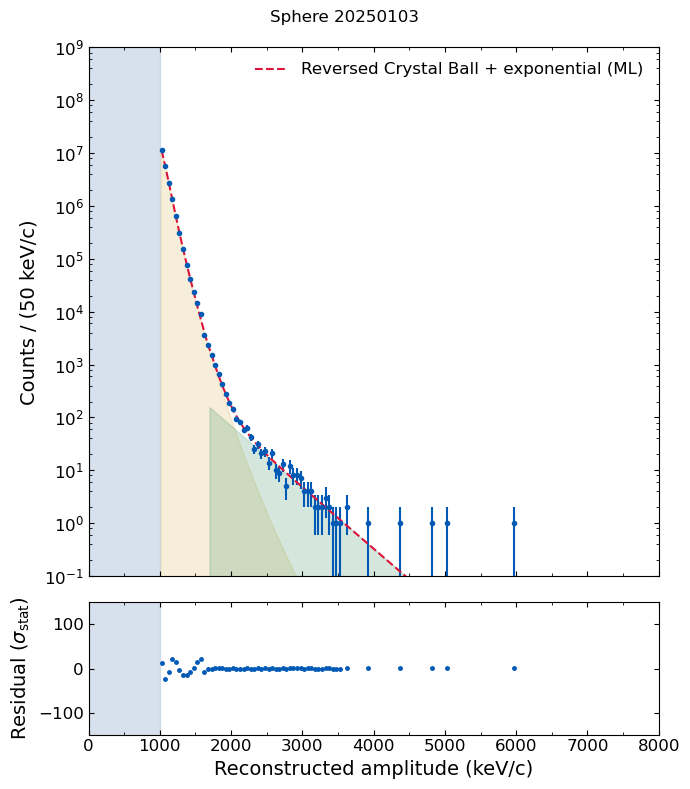

In [6]:
ntot = np.sum(hist)
args = (bc, hist)

res = minimize(fun=lambda x: nll(*x, *args), 
               method='Nelder-Mead',
               x0 = [0.999999963, 3.88913877, 18.8311789, 164.921104, 255.466148, 1700.34007, 388.650890],
               bounds = [(0.9999, 1), (3, 4), (10, 30), (100, 200), (200, 300), (1400, 2000), (300, 500)],

               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

params_nodm = res.x
nll_nodm   = res.fun

print(res.x)

plot_likelihood_fit(bc, hist, res.x)

In [13]:
def smooth_nlls(alpha_list, nlls):
    for i, nll in enumerate(nlls):
        if i == 0 or i > (nlls.size - 3):
            continue

        if np.abs(nll - nlls[i-1]) > 5 :
            # Skip the next value to avoid minimizer failing two times in a row
            nlls[i] = np.interp(alpha_list[i], [alpha_list[i-1], alpha_list[i+1]], [nlls[i-1], nlls[i+1]])

    return nlls

In [32]:
data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'

def get_upper_alpha(mx, alpha_list, nlls):
    if mx < 2:
        return np.nan

    # Remove nan from the nlls
    _nlls = nlls[~np.isnan(nlls)]
    _alpha = alpha_list[~np.isnan(nlls)]
    if _nlls.size == 0:
        return np.nan
    
    if np.max(alpha_list) < 1e-5:  # very fine search at the bottom
        mf_size = 7
        sav_size = 20
    else:
        mf_size = 7
        sav_size = 10

    # _nlls = smooth_nlls(_alpha, _nlls)
    # Remove spikes and smooth nlls using a median filer
    # and a polynomial filter
    _nlls = medfilt(_nlls, mf_size)
    _nlls = savgol_filter(_nlls, sav_size, 1)
    idx_ml = np.argmin(_nlls)
    
    # Make sure minimum point is not a spike
    # if idx_ml != 0 and idx_ml < _nlls.size-1:
    #     if np.abs(_nlls[idx_ml - 1] - _nlls[idx_ml]) > 5 and np.abs(_nlls[idx_ml+1] - _nlls[idx_ml]) > 5:
    #         _nll[idx_ml] = np.interp(_alpha[i], [_alpha[i-1], _alpha[i+1]], [_nll[i-1], _nll[i+1]])
    #         idx_ml = np.argmin(_nlls)


    if np.max(_nlls - _nlls[idx_ml]) < 5:
        return np.nan

    # Make sure NLLs are strictly increasing above the
    # maximum likelihood alpha
    idx_search = _alpha >= _alpha[idx_ml]
    if np.sum(idx_search) == 0:
        return np.nan

    delta_nlls = _nlls[idx_search] - _nlls[idx_ml]

    return np.interp(4, 2*delta_nlls, _alpha[idx_search], left=np.nan, right=np.nan)

def get_alpha_limits(mphi, sphere, dataset='coarse'):
    nlls_file = np.load(fr'{data_dir}/profile_nlls/{sphere}/profile_nlls_{sphere}_{mphi:.0e}_{dataset}.npz')

    nlls = nlls_file['nll']
    mx_list, alpha_list = nlls_file['mx'], nlls_file['alpha']

    alpha_upper = np.empty(mx_list.size)
    for i, mx in enumerate(mx_list):
        alpha_upper[i] = get_upper_alpha(mx, alpha_list, nlls[i])

    return mx_list, alpha_upper, alpha_list, nlls

def update_alpha_lim(mx_list_coarse, alpha_lim_coarse, mx_list_fine, alpha_lim_fine):
    ret = np.copy(alpha_lim_coarse)
    for i, mx_coarse in enumerate(mx_list_coarse):
        if mx_coarse < np.min(mx_list_fine) or mx_coarse > np.max(mx_list_fine):
            continue
        idx = np.argmin(np.abs(mx_list_fine - mx_coarse))
        ret[i] = alpha_lim_fine[idx]

    return ret

def get_combined_limits(lim_coarse, lim_fine_left, lim_fine_bottom=None, lim_fine_side=None):
    mx_list_left, alpha_lim_left = lim_fine_left[0], lim_fine_left[1]
    mx_list_coarse, alpha_lim_coarse = lim_coarse[0][lim_coarse[0] > 5], lim_coarse[1][lim_coarse[0] > 5]

    mx_list_full = np.concatenate([mx_list_left, mx_list_coarse])

    ## Update alpha limits based on finer calculation (but keep the coarse mx list)
    if lim_fine_bottom is not None:
        mx_list_bottom, alpha_lim_bottom = lim_fine_bottom[0], lim_fine_bottom[1]
        alpha_lim_coarse = update_alpha_lim(mx_list_coarse, alpha_lim_coarse, mx_list_bottom, alpha_lim_bottom)

        if lim_fine_side is not None:
            mx_list_side, alpha_lim_side = lim_fine_side[0], lim_fine_side[1]
            alpha_lim_coarse = update_alpha_lim(mx_list_coarse, alpha_lim_coarse, mx_list_side, alpha_lim_side)

    alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_coarse])

    # if lim_fine_bottom is not None:
    #     mx_list_bottom, alpha_lim_bottom = lim_fine_bottom[0], lim_fine_bottom[1]

    #     if lim_fine_side is None:
    #         mx_list_coarse, alpha_lim_coarse = lim_coarse[0][lim_coarse[0] > 30], lim_coarse[1][lim_coarse[0] > 30]

    #         mx_list_full = np.concatenate([mx_list_left, mx_list_bottom, mx_list_coarse])
    #         alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_bottom, alpha_lim_coarse])
    #     else:
    #         mx_list_side, alpha_lim_side = lim_fine_side[0], lim_fine_side[1]
    #         mx_list_coarse, alpha_lim_coarse = lim_coarse[0][lim_coarse[0] > 1000], lim_coarse[1][lim_coarse[0] > 1000]

    #         mx_list_full = np.concatenate([mx_list_left, mx_list_bottom, mx_list_side, mx_list_coarse])
    #         alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_bottom, alpha_lim_side, alpha_lim_coarse])
    # else:
    #     alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_coarse])

    mx_list_full, idx_unique = np.unique(mx_list_full, return_index=True)
    return mx_list_full, alpha_lim_full[idx_unique]

In [33]:
lim_10ev_coarse = get_alpha_limits(10, 'sphere_20250103', 'coarse')
lim_1ev_coarse = get_alpha_limits(1, 'sphere_20250103', 'coarse')
lim_0_1ev_coarse = get_alpha_limits(0.1, 'sphere_20250103', 'coarse')
lim_0_01ev_coarse = get_alpha_limits(0.01, 'sphere_20250103', 'coarse')

lim_10ev_fine_left = get_alpha_limits(10, 'sphere_20250103', 'fine_left')
lim_1ev_fine_left = get_alpha_limits(1, 'sphere_20250103', 'fine_left')
lim_0_1ev_fine_left = get_alpha_limits(0.1, 'sphere_20250103', 'fine_left')
lim_0_01ev_fine_left = get_alpha_limits(0.01, 'sphere_20250103', 'fine_left')

lim_1ev_veryfine_bottom = get_alpha_limits(1, 'sphere_20250103', 'veryfine_bottom')
lim_0_1ev_veryfine_bottom = get_alpha_limits(0.1, 'sphere_20250103', 'veryfine_bottom')
lim_0_01ev_veryfine_bottom = get_alpha_limits(0.01, 'sphere_20250103', 'veryfine_bottom')

lim_0_1ev_fine_side = get_alpha_limits(0.1, 'sphere_20250103', 'fine_side')
lim_0_01ev_fine_side = get_alpha_limits(0.01, 'sphere_20250103', 'fine_side')

In [42]:
combined_lim_10ev = get_combined_limits(lim_10ev_coarse, lim_10ev_fine_left)

# combined_lim_1ev = get_combined_limits(lim_1ev_coarse, lim_1ev_fine_left, lim_1ev_veryfine_bottom)
# combined_lim_0_1ev = get_combined_limits(lim_0_1ev_coarse, lim_0_1ev_fine_left, lim_0_1ev_veryfine_bottom, lim_0_1ev_fine_side)
# combined_lim_0_01ev = get_combined_limits(lim_0_01ev_coarse, lim_0_01ev_fine_left, lim_0_01ev_veryfine_bottom, lim_0_01ev_fine_side)
combined_lim_1ev = get_combined_limits(lim_1ev_coarse, lim_1ev_fine_left)
combined_lim_0_1ev = get_combined_limits(lim_0_1ev_coarse, lim_0_1ev_fine_left)
combined_lim_0_01ev = get_combined_limits(lim_0_01ev_coarse, lim_0_01ev_fine_left)

# Bad index
# bad_idx_1ev = [34, 35]
# for i in bad_idx_1ev:
#     combined_lim_1ev[1][i] = np.interp(combined_lim_1ev[0][i], [combined_lim_1ev[0][33], combined_lim_1ev[0][36]], 
#                                                                [combined_lim_1ev[1][33], combined_lim_1ev[1][36]])

# bad_idx_0_1ev = 28
# combined_lim_0_1ev[1][bad_idx_0_1ev] = np.nan

# bad_idx_0_01ev = 5
# combined_lim_0_01ev[1][bad_idx_0_01ev] = np.nan


Text(0, 0.5, '95% CL upper limit on $\\alpha_n$')

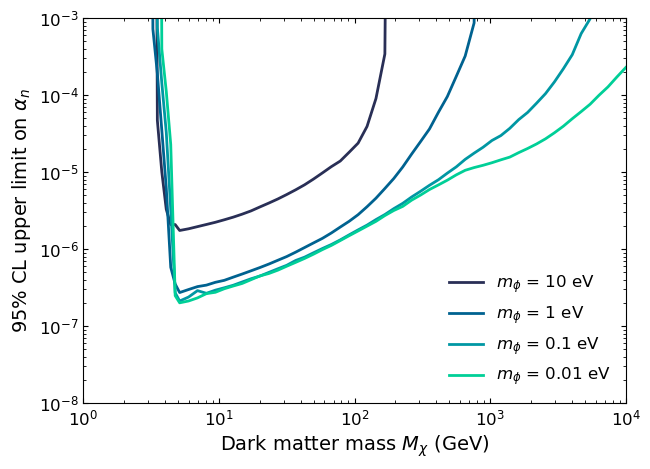

In [43]:
fig, ax = plt.subplots(figsize=(7, 5))
# colors = plt.colormaps.get_cmap('plasma').resampled(4).colors
colors = ['#292f56', '#006290', '#0097a3', '#00cf97', '#acfa70Z']

ax.plot(combined_lim_10ev[0], np.nan_to_num(combined_lim_10ev[1], nan=1e10),     '-', label='$m_\phi$ = 10 eV', color=colors[0], linewidth=2)
ax.plot(combined_lim_1ev[0], np.nan_to_num(combined_lim_1ev[1], nan=1e10),       '-', label='$m_\phi$ = 1 eV', color=colors[1], linewidth=2)
ax.plot(combined_lim_0_1ev[0], np.nan_to_num(combined_lim_0_1ev[1], nan=1e10),   '-', label='$m_\phi$ = 0.1 eV', color=colors[2], linewidth=2)
ax.plot(combined_lim_0_01ev[0], np.nan_to_num(combined_lim_0_01ev[1], nan=1e10), '-', label='$m_\phi$ = 0.01 eV', color=colors[3], linewidth=2)

plt.xlim(1e0, 1e4)
plt.ylim(1e-8, 1e-3)

plt.yscale('log')
plt.xscale('log')

plt.legend(frameon=False)
plt.xlabel(r'Dark matter mass $M_\chi$ (GeV)')
plt.ylabel(r'95% CL upper limit on $\alpha_n$')

In [21]:
lim_0_1ev_coarse[1][28]

2.894887990195179e-07

In [36]:
for i in range(26, 30):
    print(f'{i}: {lim_0_1ev_coarse[0][i]}, {lim_0_1ev_coarse[1][i]}')


26: 5.134832907437551, 2.1210873146906328e-07
27: 5.974695679970707, 2.3910012790564355e-07
28: 6.9519279617756045, 2.894887990195179e-07
29: 8.088998163995935, 2.672611106893305e-07


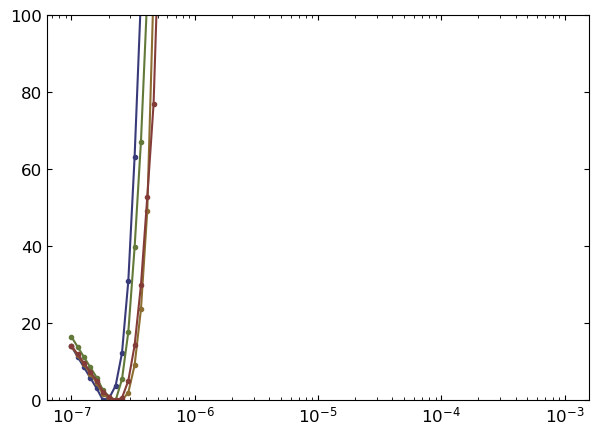

In [39]:
_alpha = lim_0_1ev_coarse[-2]

for i in range(26, 30):
    _nlls = lim_0_1ev_coarse[-1][i]
    _nlls = medfilt(_nlls, 5)
    _nlls = savgol_filter(_nlls, 10, 1)

    # plt.plot(_nlls, '.-')
    plt.plot(_alpha, _nlls - np.min(_nlls), '.-')
plt.ylim(0, 100)
plt.xscale('log')

In [45]:
lim_0_01ev_coarse[-1][36]

array([ 1.30892733e+01,  1.55645196e+01,  1.56357283e+01,  1.29215830e+01,
        1.19246131e+01,  1.50623519e+01,  9.25662124e+00,  1.00882984e+01,
        7.18819028e+00,  5.16328758e+00,  4.18793964e+00,  4.08731914e+00,
        5.38471103e-01, -6.90468788e-01, -1.17646432e+00,  8.56769621e-01,
        4.19948208e+00,  7.35882360e+00,  1.82080415e+01,  3.24068655e+01,
        4.16988677e+01,  7.10790226e+01,  1.04290216e+02,  1.47559306e+02,
        1.98502376e+02,  2.89657205e+02,  4.06640283e+02,  5.89793559e+02,
        6.09130402e+02,  1.04123244e+03,  1.23011987e+03,  1.75056828e+03,
        2.19983462e+03,  2.90180911e+03,  3.73267729e+03,  4.92715685e+03,
        6.40631479e+03,  7.96634054e+03,  1.00760428e+04,  1.27742316e+04,
        1.57521275e+04,  1.99334383e+04,  2.52968632e+04,  3.21165451e+04,
        4.05906239e+04,  5.11921174e+04,  6.44882078e+04,  8.12334384e+04,
        1.01836697e+05,  1.27188579e+05,  1.57685849e+05,  1.94423825e+05,
        2.37402947e+05,  

In [51]:
import calc_profile_nlls as calc_nlls

import importlib
importlib.reload(calc_nlls)

calc_nlls.load_sphere_data('sphere_20250103')

i_mx = 36
i_alpha_begin, i_alpha_end = 14, 16

_nlls = []
_params = []
mx = lim_0_01ev_coarse[0][i_mx]

for alpha in lim_0_01ev_coarse[2][i_alpha_begin:i_alpha_end]:
    res = calc_nlls.minimize_nll(0.01, mx, alpha)

    print(res.fun)
    print(res.x)

    _nlls.append(res.fun)
    _params.append(res.x)


/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../calc_profile_nlls.py:213: OptimizeWarning: Initial guess is not within the specified bounds
  res = minimize(fun=lambda x: nll_dm_scaled(*x, *args), x0=[*x0_bg, 1, 1],


-1.176464319229126
[9.99999962e-01 3.88403010e+00 1.92822560e+01 1.65269541e+02
 2.55372511e+02 1.70034077e+03 2.99988635e+02 1.00836821e+00
 1.01469801e+00]
0.8567696213722229
[9.99999963e-01 3.88457380e+00 1.92477128e+01 1.65203813e+02
 2.55389937e+02 1.70034181e+03 2.99999995e+02 1.01289708e+00
 9.53234701e-01]


In [62]:
hist_norm = n_window * scaling

def get_dm_hist(mphi, mx, alpha_n, q_scale, n_scale):
    qq, drdqzn = calc_nlls.read_dm_rate(mphi, mx, alpha_n)
    qq_scaled = qq * q_scale
    drdqzn_scaled = np.interp(qq_scaled, qq, drdqzn*q_scale, left=0, right=0) * n_scale**2

    eff_qq = func2(qq_scaled, *eff_coefs)
    hist_dm = eff_qq * drdqzn_scaled * hist_norm

    return qq, hist_dm

def plot_likelihood_fit_dm(bc, hist, mphi, mx, alpha_n, res_x):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    qq, hist_dm = get_dm_hist(mphi, mx, alpha_n, res_x[-2], res_x[-1])

    if qq.size > bc.size:
            hist = np.pad(hist, (0, qq.size - bc.size))
            bc = qq

    ana_threshold = 1000

    idx = bc > ana_threshold
    bi = bc[idx]

    ntot = np.sum(hist) - np.sum(hist_dm)

    hist_fit_ml_dm = get_mui(*res_x[:-2], bi, ntot) + hist_dm[idx]

    a, alpha, n, mu, sigma, cutoff, xi = res_x[:-2]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.errorbar(bi, hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)
    ax.plot(bi, hist_fit_ml_dm, '--', color='#DC143C', label='Maximum likelihood fit')
    ax.plot(qq, hist_dm, 'b:', label=f'DM component \n($M_\\chi$ = {mx:.1f} GeV, $\\alpha_n$={alpha_n:.1e}, $m_\\phi$ = {mphi:.2f} eV)', alpha=0.9)

    xx2 = np.linspace(1020, 10000, 500)
    crystal_ball_hist = ntot * 50 * a * crystal_ball_rev_normalized(xx2, alpha, n, mu, sigma)
    ax.fill_between(xx2, 0, crystal_ball_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(cutoff, 10000, 500)
    expo_hist = ntot * 50 * (1 - a) * expo_corrected(xx1, cutoff, xi)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')
    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    # ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')
    ax.set_xlabel('Reconstructed amplitude (keV/c)')

    ax.set_title('Sphere 20250103')

    return fig, ax

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Sphere 20250103'}, xlabel='Reconstructed amplitude (keV/c)', ylabel='Counts / (50 keV/c)'>)

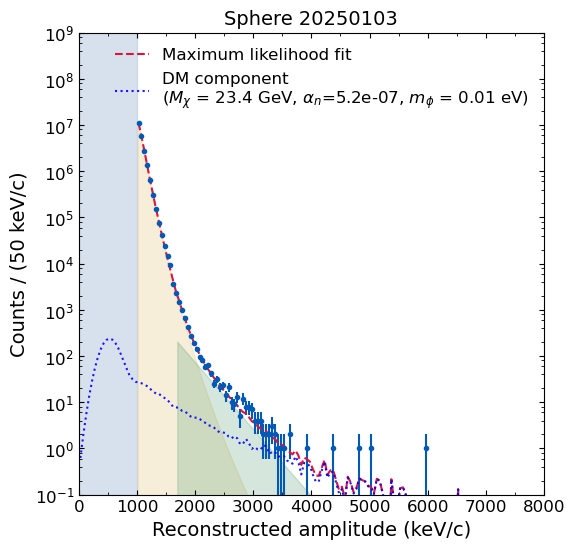

In [63]:
plot_likelihood_fit_dm(bc, hist, 0.01, mx, lim_0_01ev_coarse[2][14], _params[0])

In [25]:
for i in range(len(_nlls)):
    print(_params[i])

[9.99999989e-01 3.88917662e+00 1.86514822e+01 1.64965641e+02
 2.55454664e+02 1.97500000e+03 5.11675881e+02 1.04735158e+00
 4.77948283e-01]
[9.99999978e-01 3.89001320e+00 1.87107961e+01 1.65031170e+02
 2.55448293e+02 1.68033607e+03 5.48110116e+02 1.11824209e+00
 4.84950956e-01]
[9.99999988e-01 3.89180592e+00 1.85569822e+01 1.65012918e+02
 2.55449909e+02 1.86748393e+03 2.55408586e+02 1.13496932e+00
 7.46752041e-01]


In [83]:
qq

array([2.500000e+01, 7.500000e+01, 1.250000e+02, ..., 1.921475e+06,
       1.921525e+06, 1.921575e+06])

In [82]:
hist_dm

array([1459258.17862697,       0.        ,       0.        , ...,
             0.        ,       0.        ,       0.        ])

/tmp/tmp.FgVCTSFztk/ipykernel_3542652/974970523.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.FgVCTSFztk/ipykernel_3542652/974970523.py:43: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


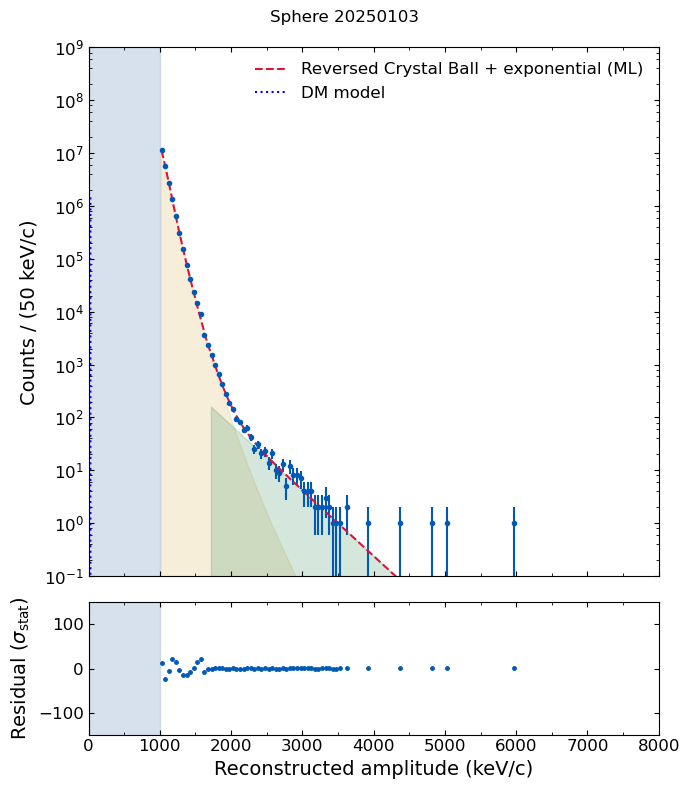

In [79]:
fig, axes = plot_likelihood_fit(bc, hist, _params[-1][:-2])

qq, hist_dm = get_dm_hist(0.01, mx, lim_0_01ev_coarse[2][69], res.x[-2], res.x[-1])
axes[0].plot(qq, hist_dm, 'b:', label='DM model')
axes[0].legend(frameon=False)

In [20]:
n_scale = np.linspace(0, 2, 100)
neuts = np.empty_like(n_scale)

def get_neut_term(n_scale):
    sigma_n = np.sqrt(3) * 0.054

    if np.abs(n_scale - 1) > 0.5 * sigma_n:
        neut_term = (n_scale - 1)**2 / (2 * sigma_n**2) + (n_scale - 1)**2 / (1e-2 * sigma_n**2)
    else:
        neut_term = (n_scale - 1)**2 / (2 * sigma_n**2)

    return neut_term

for i, n in enumerate(n_scale):
    neuts[i] = get_neut_term(n)

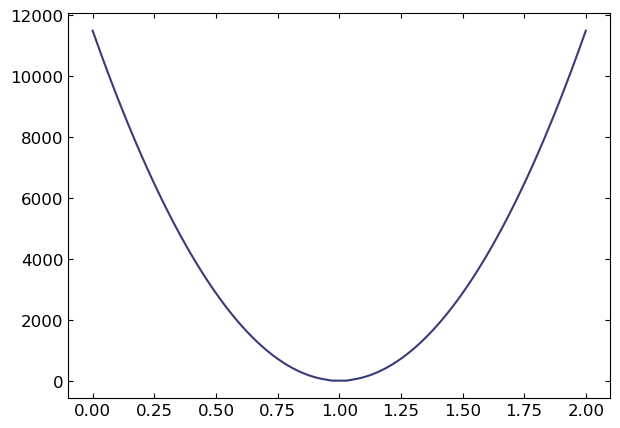

In [21]:
plt.plot(n_scale, neuts)